### <p style="text-align: right;"> &#9989; Andrew Koren</p>

## Code from previous ICAs, etc here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [5]:
def forsub(L,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in range(n):
        val = 0.
        for j in range(i):
            val += L[i,j]*xs[j]
        xs[i] = (bs[i] - val)/L[i,i]
    return xs


def backsub(U,bs):
    n = bs.size
    xs = np.zeros(n)
    for i in reversed(range(n)):
        val = 0.
        for j in range(i+1,n):
            val += U[i,j]*xs[j]
        xs[i] = (bs[i] - val)/U[i,i]
    return xs

def ludec( A ):
    n = A.shape[0]
    U = np.copy(A)
    L = np.identity(n)

    for j in range(n-1):
        for i in range(j+1,n):
            coeff = U[i,j]/U[j,j]
            U[i,j:] -= coeff*U[j,j:]
            L[i,j] = coeff

    return L, U

def mat_inverse(A):
    n = A.shape[0]
    L, U = ludec(A)
    I = np.eye(n)
    inv_A = np.zeros((n, n))
    for i in range(n):
        Y = forsub(L, I[:, i])
        X = backsub(U, Y)
        inv_A[:, i] = X

    return inv_A

# power iteration method to find the largest eigenvalue and its eigenvector
# Input:
# A -- (square) matrix
# max_iter -- maximum number of iterations
# Output:
# largest eigenvalue, its eigenvector
def power_method( A, max_iter=100 ):
    '''
    currently no convergence evaluation
    '''

    # read off the dimension
    n = A.shape[0]

    b = np.ones(n)
    for _ in range(max_iter):
        bk = A@b
        b = bk / np.linalg.norm(bk)

    # Rayleigh Quotient
    eigenval = b@A@b/(b@b)

    return eigenval, b

def qrdec(A):
    n = A.shape[0]
    Ap = np.copy(A)
    Q = np.zeros((n,n))
    R = np.zeros((n,n))
    for j in range(n):
        for i in range(j):
            R[i,j] = Q[:,i]@A[:,j]
            Ap[:,j] -= R[i,j]*Q[:,i]

        R[j,j] = np.linalg.norm(Ap[:,j])
        Q[:,j] = Ap[:,j]/R[j,j]
    return Q, R


# PHY480 Homework 3


This homework contains exercises on the eigenvalue problems. There are two parts:

- tensor of inertia,
- one-dimensional quantum harmonic oscillator.

For the first part we will use the QR method that we coded ourselves in class, for the second part the NumPy functions, such as `numpy.linalg.eig`.

**There are 7 problems with the total of 37 points.**

**The deadline for the homework is Wednesday, March 19, 2025, 6:00 pm.**


## Eigenvalue problems

### Inertia tensor

**Problem 1 (6 points).** Consider the following geometrical shape in three dimensions: a region of space bounded by planes $x=0$, $y=0$, $z=0$ and a sphere $x^2+y^2+z^2=R^2=1$, where $x\geqslant0$, $y\geqslant0$, $z\geqslant0$ and $x^2+y^2+z^2\leqslant1$. (This is esentially $1/8$ slice of a sphere with the center at the origin.) Let this geometrical shape be filled with mass density $\rho=1$.

The tensor of inertia is a $3\times3$ symmetric matrix $I_{ij}$ whose elements are given by (here $V$ is the volume occupied by the shape, the mass density $\rho=1$ and $r^2=x^2+y^2+z^2$):

$$
I_{xx}=\int_V dV\, (r^2-x^2),
$$

for the diagonal elements (for $I_{yy}$ and $I_{zz}$ replace $x$ with $y$ and $z$, correspondingly), and

$$
I_{xy}=\int_V dV\, (-xy),
$$

for the non-diagonal elements (replace $x$ and $y$ correspondingly for the other non-diagonal elements).

Evaluate the tensor of inertia for the described shape with respect to the origin, either analytically (preferable) or numerically. (It is convenient to work in spherical coordinates.)

# Integrals:

$$
\int dV = \int_0^{2\pi} \int_0^\pi \int_0^R \rho^2 \sin \phi d\rho d\phi d\theta  \\
x = \rho \cos \theta \sin \phi \\
y = \rho \sin \theta \sin \phi \\
z = \rho \cos \phi
$$

Our bounds are less general

$$
\int_0^{\pi/2} \int_0^{\pi/2} \int_0^1
$$

In [6]:
import sympy as sm
from sympy import cos, sin

rho, theta, phi = sm.symbols('rho theta phi')
x = rho * cos(theta) * sin(phi)
y = rho * sin(theta) * sin(phi)
z = rho * cos(phi)

integrate_with_bounds = lambda integrand: sm.integrate(integrand * rho*rho * sin(phi), (rho, 0, 1), (theta, 0, sm.pi/2), (phi, 0, sm.pi/2))

display(integrate_with_bounds(rho*rho-x*x)) #same for y, z
display(integrate_with_bounds(-x*y)) #same for xz, yz


pi/15

-1/15

In [7]:
# tensor of inertia for 1/8 slice of a filled sphere
# REPLACE 0s WITH PROPER VALUES
from numpy import pi

Itensor = np.array( [   \
    [ pi, -1, -1], \
    [ -1, pi, -1], \
    [ -1, -1, pi]  \
])/15

Itensor

array([[ 0.20943951, -0.06666667, -0.06666667],
       [-0.06666667,  0.20943951, -0.06666667],
       [-0.06666667, -0.06666667,  0.20943951]])

**Problem 2 (5 points).** Use the QR method we considered in class to diagonalize the tensor of inertia and find its eigenvalues -- the principal moments of intertia. Sort the eigenvalues in ascending order. Check against `numpy.linalg.eig` calculation.

**Note:** For this rigid body you may expect degenerate eigenvalues.

Finding eigenvalues with QR:
1. Symmetric matrix
2. QR = A
3. A' = RQ
4. repeat, diagonal is eigenvalues

$A' = Q^T A Q$ is the same as 3.

In [8]:
def eigenvalues_with_QR( A, max_iter=100, print_iter=False ):

    # store a copy so that the original matrix is not disturbed
    Ak = A.copy()
    for i in range(max_iter):
        eigenvals = np.sort(np.diagonal(Ak))

        Q, R = qrdec(Ak)
        Ak = R@Q # also Q.T@Ak@Q
        
        if all(eigenvals == np.sort(np.diagonal(Ak))): #convergence to machine accuracy
            return 0, eigenvals
        
        if print_iter:
            print(i, eigenvals)

    return 1, eigenvals # did not reach machine accuracy

In [9]:
success, eigenvals = eigenvalues_with_QR(Itensor) # repeated eigenvalue, makes sense
print(eigenvals)
print(np.sort(np.linalg.eig(Itensor)[0]))

[0.07610618 0.27610618 0.27610618]
[0.07610618 0.27610618 0.27610618]


They're the same!

**Problem 3 (5 points).** Using the inverse power iteration method we considered in class, find the eigenvectors corresponding to the eigenvalues. Make sure the eigenvectors are normalized to have unit length. Check against `numpy.linalg.eig`.


In [10]:
def invpower_method( A, sigma=0, max_iter=100 ):
    
    # read off dimensions
    n = A.shape[0]
    # prepare the inverse for the power iteration method
    B = mat_inverse( A - sigma*np.eye( n ) )
    kappa, Bvec = power_method(B) #A and B have the same eigenvectors
    eigenvalue = sigma + 1/kappa

    return eigenvalue, Bvec

In [11]:
invpower_method(Itensor, sigma=eigenvals[1], max_iter=int(1e7))[1]

array([ 0.40824829,  0.40824829, -0.81649658])

In [12]:
eigenvectors = [invpower_method(Itensor, sigma=eigenval, max_iter=int(1e7))[1] for eigenval in eigenvals]
print(eigenvectors)
print(np.linalg.eig(Itensor)[1])

[array([0.57735027, 0.57735027, 0.57735027]), array([ 0.40824829,  0.40824829, -0.81649658]), array([ 0.40824829,  0.40824829, -0.81649658])]
[[ 0.81649658 -0.57735027  0.3782647 ]
 [-0.40824829 -0.57735027 -0.81577967]
 [-0.40824829 -0.57735027  0.43751497]]


A bit out of order but we got there eventually. Eigenvalue degeneracy means we have a repeated eigenvector, also not all eigenvectors are orthogonal

**Problem 4 (5 points).** Eigenvectors corresponding to a degenerate eigenvalue may not be orthogonal. In fact, the inverse power iteration method may converge to the same eigenvector for degenerate eigenvalues. If some eigenvalues in this problem are degenerate, you can still _choose_ their eigenvectors to be orthogonal. Based on the eigenvectors computed by the QR method, build a set of three mutually orthogonal vectors. They will represent the _principal axes_ of the tensor of inertia. Demonstrate that the chosen vectors are orthonormal and that in the coordinate system where these vectors coincide with $x$, $y$, $z$ directions the tensor of inertia is diagonal.

We know eigenval 2 & 3 are the same, so we'll make eigenvec 3

In [13]:
def proj(u, v):
    '''
    projects u onto V axis
    '''
    return (u@v)/(v@v)*v

def make_orthogonal_basis(orthogonal_vectors):
    dim = orthogonal_vectors[0].size
    basis = [*orthogonal_vectors] # just to be safe
    test_val = 0
    while len(basis) < dim:
        # create vector outside span of basis
        u = np.zeros(dim)
        u[test_val] = 1
        for v in basis:
            u = u - proj(u, v)
        if sum(u) == 0:
            test_val += 1
        else:
            basis.append(u)
    return basis

basis = make_orthogonal_basis(eigenvectors[:2])

assert np.isclose(basis[0]@basis[1],0)
assert np.isclose(basis[1]@basis[2],0)
assert np.isclose(basis[2]@basis[0],0)

R = np.array(basis).T
rotated_Itensor = R.T@Itensor@R


rotated_Itensor[np.isclose(rotated_Itensor, 0)] = 0
rotated_Itensor # note first two are eigenvals, is the third value arbitrary?

array([[0.07610618, 0.        , 0.        ],
       [0.        , 0.27610618, 0.        ],
       [0.        , 0.        , 0.13805309]])

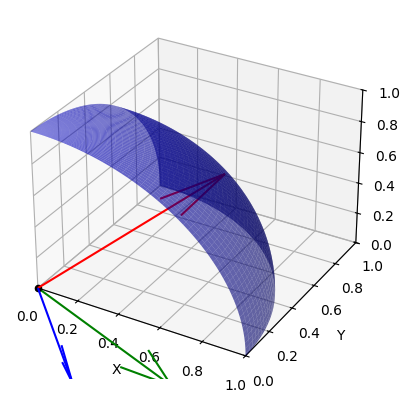

In [14]:
# Define the radius
radius = 1

# Define the angle ranges for 1/8th section of a sphere (0 to pi/2 for both theta and phi)
theta = np.linspace(0, np.pi/2, 100)
phi = np.linspace(0, np.pi/2, 100)

# Create a meshgrid for theta and phi
theta, phi = np.meshgrid(theta, phi)

# Calculate the x, y, and z coordinates
x = radius * np.sin(theta) * np.cos(phi)
y = radius * np.sin(theta) * np.sin(phi)
z = radius * np.cos(theta)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 1/8th section of the sphere in the +++ region
ax.plot_surface(x, y, z, color='b', alpha=0.6)

ax.quiver(0, 0, 0, R.T[0, 0], R.T[0, 1], R.T[0, 2], color='r', label='new basis 1')
ax.quiver(0, 0, 0, R.T[1, 0], R.T[1, 1], R.T[1, 2], color='g', label='new basis 2')
ax.quiver(0, 0, 0, R.T[2, 0], R.T[2, 1], R.T[2, 2], color='b', label='new basis 3')

ax.scatter(0,0,0, color='black')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

# Show the plot
plt.show()

###  Quantum harmonic oscillator

In general, a quantum-mechanical system can be described by a _wave function_ $\psi(\vec{r},t)$ that satisfies a time-dependent Schrodinger equation:

$$
i\hbar \frac{\partial \psi}{\partial t}=\hat H\psi,
$$

where $\hat H$ is the Hamiltonian (operator) and we set $\hbar$ to 1 for simplicity. If the Hamiltonian does not depend on time $t$ explicitly, the problem can be reduced to a _time-independent_ Schrodinger equation:

$$
\hat H\psi =E\psi
$$

that describes _stationary states_. Supplemented with some boundary conditions the above equation forms an eigenvalue problem for the operator $\hat H$. Its solution gives us the energy levels $E$ (eigenvalues) that the system can occupy and the wave functions or state vectors $\psi(\vec{r})$ (eigenvectors). In this formulation this is an operator eigenvalue problem. It can be reduced to a matrix eigenvalue problem.

The Hamiltonian is $\hat H=\hat T + \hat V$, where $\hat T$ is the kinetic energy and $\hat V$ potential energy operators. We can simplify the problem by considering a single degree of freedom in one dimension with a unit mass $m=1$. Then

$$
\hat T = - \frac{1}{2}\,\frac{d^2}{dx^2}.
$$

For the potential energy part, consider a harmonic oscillator potential (the frequency $\omega=1$ for simplicity):

$$
\hat V = \frac{1}{2}x^2.
$$

As this potential only supports bound states, a reasonable boundary condition is the wave function vanishing at infinity. All together, we have the following operator eigenvalue problem:

$$
\left(- \frac{1}{2}\,\frac{d^2}{dx^2}+\frac{1}{2}x^2\right)\psi(x)=E\psi(x),
$$

$$
\psi(x \to\pm\infty)\to0.
$$


**Problem 5 (4 points).** Let us turn the one-dimensional operator eigenvalue problem into a matrix eigenvalue problem. First, let us restrict the range of $x$ to $-x_{max}\leqslant x \leqslant x_{max}$ (where $x_{max}$ is obviously chosen to be positive). Let $N$ (strictly even) be the number of intervals to which we divide the range of $x$. The size of the interval in that case is

$$
\Delta x = \frac{2 x_{max}}{N}.
$$

The total number of points at which we are going to find the solution is $N+1$. (Example: $x_{max}=2$, $N=4$, then $\Delta x = 1$ and the active points are $x=-2,-1,0,1,2$.) Choosing $N$ to be even simply means that 0 is included in the point set. To incorporate the boundary conditions, we set $\psi(x)=0$ for any $|x|>x_{max}$. Then the solution to the discrete problem is a vector of $N+1$ entries -- aproximation to $\psi(x)$ at the discrete set of $N+1$ points $x_i$ that we number in 0-based counting $i=0,1,\dots,N$. Then, we have a matrix eigenvalue problem of the form:

$$
\sum_{j=0}^{N}H_{ij}\psi_j = E\psi_i,
$$

where $H_{ij}$ approximates the continuous $\hat H$ shown above.

Recall that we discussed a finite-difference approximation to the second derivative of a function at point $i$ that involves also values at points $i-1$ and $i+1$. Write down a finite-difference approximation that together with the potential energy term gives $H_{ij}$. You should produce a tridiagonal matrix (i.e. the only non-zero entries are on the main diagonal, and the diagonals above and below). Complete the function below that produces $H_{ij}$. (Think how to properly use the boundary conditions for the first and last row of $H_{ij}$.)

CFD:

$$
\frac{df(i)}{dx} \approx \frac{f(i+1) - f(i-1)}{2\Delta x} \\
\frac{d}{dx} \frac{df(i)}{dx} \approx \frac{f(i+2) - 2f(i) + f(i-2)}{4\Delta x^2}
$$
Aparently it is better to use a different CFD though
$$
\frac{d^2 f(x_i)}{dx^2}=\frac{f(x_{i+1}) - 2f(x_i) + f(x_{i-1})}{\Delta x^2} \\
$$

In [15]:
# make the Hamiltonian matrix
# Input:
# N -- number of intervals, always even
# xmax -- bound on the x-range
# Output:
# the Hamiltonian matrix (N+1)x(N+1), should be tridiagonal
def make_H( N=10, xmax=3 ):
    
    H = np.zeros( (N+1,N+1) )
    Δx = 2*xmax/N
    x = np.arange(-xmax, xmax+Δx, Δx)

    if N%2 != 0: # N must be even
        return H, x


    for i in range(N+1):
        H[i,i] = x[i]**2/2 + 1/Δx**2
        if i+1 <= N:
            H[i+1,i] = -0.5/Δx**2
            H[i,i+1] = -0.5/Δx**2

    
    return H, x

**Problem 6 (5 points).** In this part of the exercise we use `numpy.linalg.eig`, since it is much faster than our QR method. (As many NumPy subroutines actually call C or Fortran libraries, they are not written in Python.)
Find the eigenvalues and eigenvectors of the Hamiltonian matrix $H_{ij}$. The eigenvalues and corresponding eigenvectors may be in some random order and the eigenvectors may have a random sign. Apply the following two transformations:

- sort the eigenvalues (and eigenvectors) in the ascending order,
- flip the sign of the eigenvector if needed, so that for all eigenvectors the approach $x\to x_{max}$ is from _above_.

Print out a few low-lying eigenvalues and plot the corresponding eigenvectors. Do they match your expectations? How well the theoretical values are reproduced?

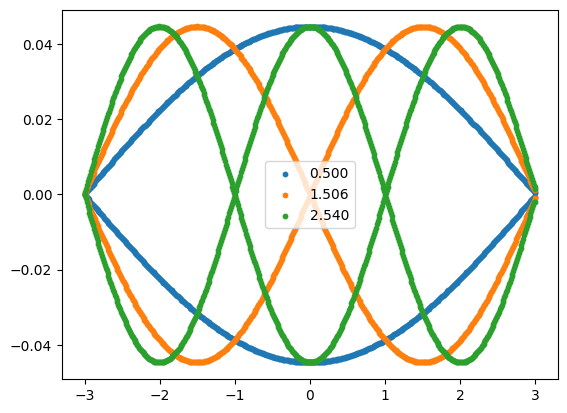

In [16]:
# number of eigenvectors to plot
Ne = 3

# experiment with different pairs of (xmax,N), starting with low values,
# for example, start with xmax=3, try N=10, 20, 50,
# increase xmax to 4,5 and higher and try different N starting from low values
# (work with combinations that keep dx=2*xmax/N less than 1)
xmax = 3
N = 1000

assert 2*xmax/N < 1
H, x = make_H( N, xmax )

# YOUR CODE HERE
eigenvals, eigenvecs = np.linalg.eig(H)

# sorting
idx = np.argsort(eigenvals)
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx] 

# makes x=x_max positive
for i in range(len(eigenvecs)):
    if eigenvecs[-1, i] < 0:
        eigenvecs[:, i] *= -1


for eigenvec, eigenval in zip(eigenvecs[:Ne], eigenvals[:Ne]):
    plt.scatter(x, eigenvec, label=f'{eigenval:.3f}', s=10)
plt.legend()

**Problem 7 (7 points).** To compare with the exact solution to the one-dimensional quantum harmonic oscillator problem the state vectors (eigenvectors of $H_{ij}$ that you found) need to be properly normalized. Namely, the normalization condition is

$$
\int dx |\psi(x)|^2=1.
$$

Use a numerical integration scheme to properly normalize the eigenvectors for the low-lying states you found in the previous problem. Plot the normalized eigenvectors together with the exact solutions.

**Note:** The exact solution is given in terms of the Hermite polynomials. Consult the relevant literature on quantum mechanics (or Wikipedia).

$$
\psi_n(x) = \left( \frac{1}{\sqrt{2^n n! \sqrt{\pi}}} \right) e^{-x^2/2} H_n(x) \\
\psi_0(x) = \left( \frac{1}{\sqrt{\sqrt{\pi}}} \right) e^{-x^2/2} \\
\psi_1(x) = \left( \frac{1}{\sqrt{2 \sqrt{\pi}}} \right) e^{-x^2/2} (2x) \\
\psi_2(x) = \left( \frac{1}{\sqrt{4 \sqrt{\pi}}} \right) e^{-x^2/2} (-2 + 4x^2) \\

$$

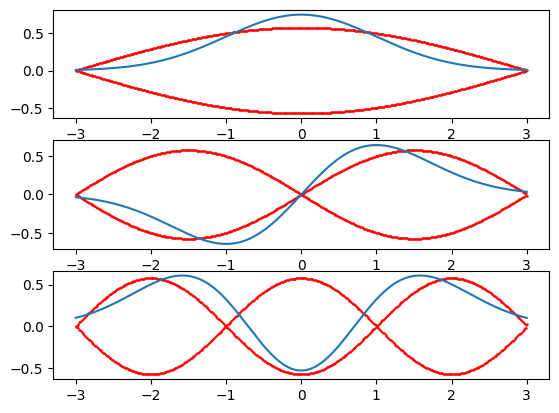

In [17]:
from scipy.integrate import simpson
from math import factorial

norm_eigenvecs = [eigenvec/np.sqrt(simpson(y=abs(eigenvec**2), x=x)) for eigenvec in eigenvecs[:3]]

def exact_sol(x, n):
    '''
    n = 0,1,2
    '''
    n0 = 1
    n1 = 2*x
    n2 = -2+4*x**2
    ni = [n0, n1, n2]

    return 1/(np.sqrt(2**n*factorial(n)*np.sqrt(np.pi)))*np.exp(-x**2/2)*ni[n]


fig, axs = plt.subplots(3, 1)
for i in range(3):
    axs[i].scatter(x, norm_eigenvecs[i], s=.5, color='red')
    axs[i].plot(x, exact_sol(x,i))

&#169; Copyright 2025,  Michigan State University Board of Trustees